In [64]:
import pandas as pd
import numpy as np
spam = pd.read_csv('spam.csv')
cancer = pd.read_csv('cancer.csv')

**Implement the kNN algorithm and calculate Leave-one-out error on both datasets for 1 to 10 neighbors.**

In [65]:
import scipy.spatial
def dist(X, df):
    features = df.drop(['label'], axis=1)
    distances = scipy.spatial.distance.cdist(features.iloc[:, :], [X], metric='euclidean').ravel()
    return np.argsort(distances)

In [66]:
def most_frequent_label(df):
    return df['label'].value_counts().idxmax()

In [67]:
def KNN(df, X, k):
    distances = dist(X, df)
    return [most_frequent_label(df.take(distances[:i])) for i in range(1, k + 1)]

In [68]:
import matplotlib.pyplot as plt
def plot_error(err):
    plt.plot(list(range(1, len(err) + 1)), err)
    plt.xlabel('k')
    plt.ylabel('error')
    plt.show()

In [69]:
def leave_one_out_error(df, k=10):
    n = df.shape[0]
    err = np.zeros(k, dtype = int)
    features = df.drop(['label'], axis=1)
    for i in range(n):
        df_drop_one = df.drop(df.index[i])
        X = features.iloc[i, :]
        knn_res = KNN(df_drop_one, X, k)
        for j in range(1, k + 1):
            err[j - 1] += 0 if df.at[i, 'label'] == knn_res[j - 1] else 1
    res = np.vectorize(lambda x : x / n)(err)
    plot_error(res)
    return res

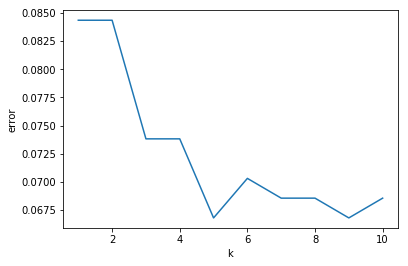

array([0.08435852, 0.08435852, 0.07381371, 0.07381371, 0.06678383,
       0.07029877, 0.0685413 , 0.0685413 , 0.06678383, 0.0685413 ])

In [70]:
leave_one_out_error(cancer)

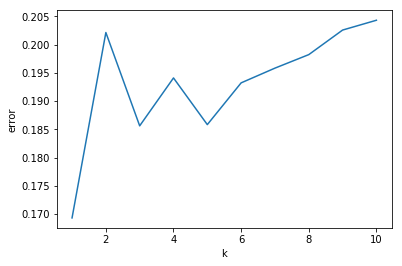

array([0.16931102, 0.20212997, 0.18561182, 0.19408824, 0.18582917,
       0.19321887, 0.19582699, 0.19821778, 0.20256466, 0.20430341])

In [71]:
leave_one_out_error(spam)

**Scale all features with MinMax scaler to [0,1] and calculate Leave-one-out error on both datasets for 1 to 10 neighbors.**

In [72]:
def scale(df):
    from sklearn import preprocessing
    scaler = preprocessing.MinMaxScaler()
    features = df.drop(['label'], axis=1)
    scaled_df = scaler.fit_transform(features)
    scaled_df = pd.DataFrame(scaled_df, columns=list(features))
    scaled_df['label'] = df['label']
    return scaled_df

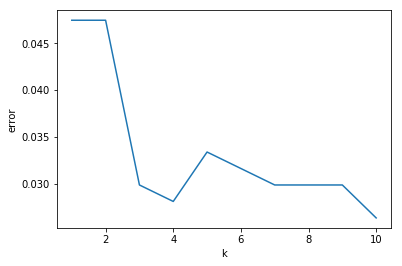

array([0.04745167, 0.04745167, 0.02987698, 0.02811951, 0.03339192,
       0.03163445, 0.02987698, 0.02987698, 0.02987698, 0.02636204])

In [73]:
leave_one_out_error(scale(cancer))

c:\users\olga\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


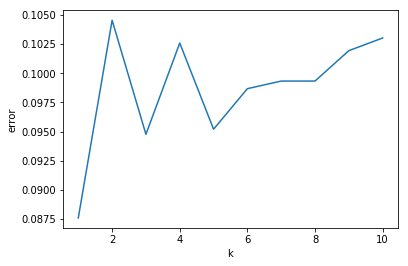

array([0.08758965, 0.10454249, 0.09476201, 0.10258639, 0.0951967 ,
       0.0986742 , 0.09932623, 0.09932623, 0.10193436, 0.10302108])

In [74]:
leave_one_out_error(scale(spam))

**Implement the k-means algorithm and cluster data point into [2,3,4,5] clusters.**

In [70]:
import pandas as pd
import numpy as np
blob = pd.read_csv('blobs.csv')

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def show_clusters(clusters):
    facet = sns.lmplot(data=clusters, x='X', y='Y', hue='cluster', 
                   fit_reg=False, legend=True, legend_out=True)

In [72]:
from scipy.spatial import distance
import numpy as np
import pandas as pd
from scipy import ndimage
def k_means(centers, points, df):
    points_to_clusters = df.copy()
    distances = distance.cdist(points, centers, 'euclidean')
    points_to_clusters['cluster'] = np.argmin(distances, axis=1)
    clusters_with_centers = points_to_clusters.groupby('cluster').mean()
    if (np.allclose(np.subtract(centers,
                       clusters_with_centers.values),
                    np.zeros((len(centers), len(centers[0]))))):
            return points_to_clusters
    return k_means(clusters_with_centers.values, points, df)

In [73]:
import random
def k_means_advanced(df, k):
    points = df.values
    center = points[random.randint(0, len(points) - 1)]
    centers = [center]
    for _ in range(k - 1):
        distances = distance.cdist(points, [center], 'euclidean').ravel()
        s = sum(distances)
        prob = list(map(lambda x : x / s, distances))
        center = points[np.random.choice(len(points), p=prob)]
        centers.append(center)
    return k_means(centers, points, df)

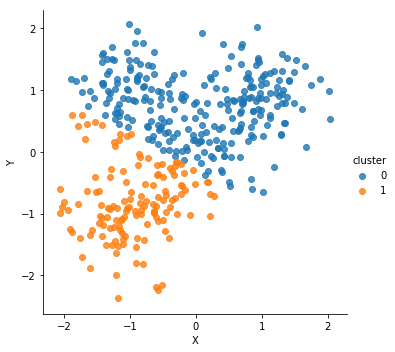

In [74]:
show_clusters(k_means_advanced(blob, 2))

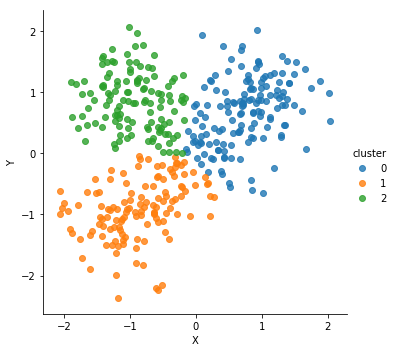

In [75]:
show_clusters(k_means_advanced(blob, 3))

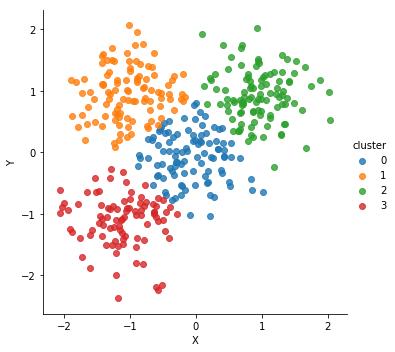

In [76]:
show_clusters(k_means_advanced(blob, 4))

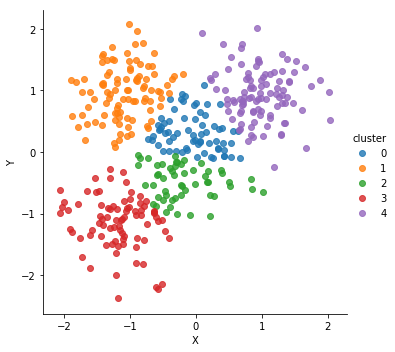

In [77]:
show_clusters(k_means_advanced(blob, 5))

**Implement the DBSCAN algorithm and find parameters for clustering into [2,3,4,5] clusters.**

In [78]:
from scipy.spatial import distance
import pandas as pd
import numpy as np
blob = pd.read_csv('blobs.csv')

def dfs(point_id, c, neighbors, points_with_labels, min_points, first_point_in_cluster=True):
    if point_id in points_with_labels:
        return False
    if len(neighbors[point_id][0]) < min_points:
        if not first_point_in_cluster:
            points_with_labels[point_id] = c
        return False
    points_with_labels[point_id] = c
    for neib in neighbors[point_id][0]:
        dfs(neib, c, neighbors, points_with_labels, min_points, False)
    return True

def dbscan(points, eps, min_points):
    distances = np.array(distance.cdist(points.iloc[:, :], points.iloc[:, :], 'euclidean'))
    in_area = np.vectorize(lambda x : 1 if x <= eps else 0)(distances)
    neighbors = [ np.asarray(np.nonzero(t)) for t in in_area]
    points_with_labels = {}
    cluster_id = 0
    for point_id in range(len(neighbors)):
        new_cluster_created = dfs(point_id, cluster_id, neighbors, points_with_labels, min_points)
        if new_cluster_created:
            cluster_id += 1
    result = points.copy()
    result['cluster'] = np.array([points_with_labels.get(t) if t in points_with_labels else np.nan for t in range(len(result))])
    return result[np.isfinite(result['cluster'])]


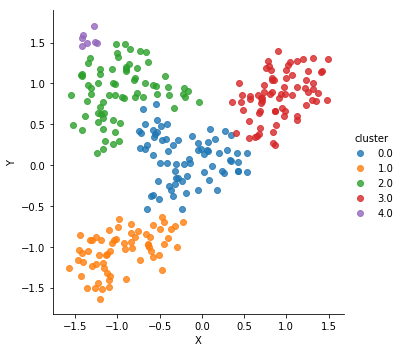

In [79]:
show_clusters(dbscan(blob, 0.2, 7))

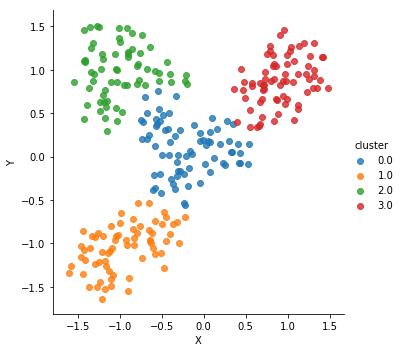

In [80]:
show_clusters(dbscan(blob, 0.22, 9))

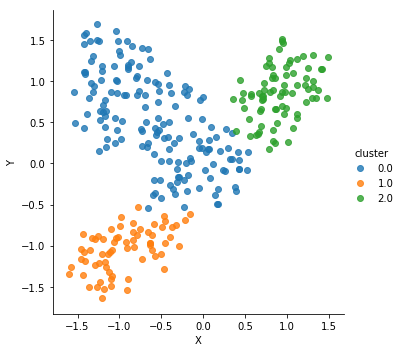

In [81]:
show_clusters(dbscan(blob, 0.21, 7))

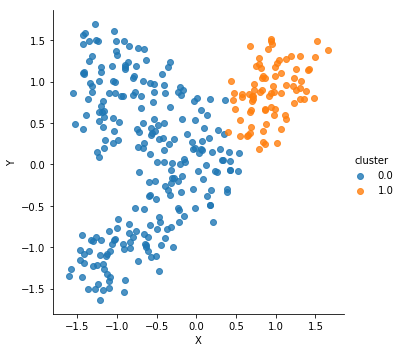

In [82]:
show_clusters(dbscan(blob, 0.21, 6))

**Cluster datapoints into [2,3,5,10] clusters with k-Means and calculate the Purity metric.**

In [83]:
import pandas as pd

cancer = pd.read_csv('cancer.csv')
def purity_metric_for_k_means(df, k):
    res = k_means_advanced(df.drop(['label'], axis=1), k)
    clusters_with_labels = pd.DataFrame()
    clusters_with_labels['cluster'] = res['cluster']
    clusters_with_labels['label'] = df['label']
    correct_res = 0
    all_res = 0
    
    clusters_grouped_label = clusters_with_labels.groupby('cluster')['label'].apply(list).apply(lambda x : {i:x.count(i) for i in x})
    for _, value in clusters_grouped_label.iteritems():
        correct_res += max(value.values())
        all_res += sum(value.values())
    return correct_res / all_res
                                      

In [84]:
purity_metric_for_k_means(cancer, 2)

0.8541300527240774

In [85]:
purity_metric_for_k_means(cancer, 3)

0.8840070298769771

In [86]:
purity_metric_for_k_means(cancer, 5)

0.8875219683655536

In [88]:
purity_metric_for_k_means(cancer, 10)

0.9103690685413005

**Implement the Agglomerative Clustering and output the clustering into [2,3,4,5] clusters.**

In [89]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

def average_distance(cluster):
    distances = distance.cdist(cluster, cluster, 'euclidean')
    return np.average(distances[np.nonzero(distances)])


def to_dataframe(clusters):
    res = pd.DataFrame(columns=['X', 'Y', 'cluster'])
    for i in range(len(clusters)):
        for point in clusters[i]:
            data = {'X' : [point[0]],
                   'Y' : [point[1]],
                   'cluster' : [i]}
            row = pd.DataFrame(data)
            res = res.append(row, ignore_index = True)
    return res

def alglomerative_clustering(kths, points):
    clusters = [np.array([point]) for point in points]
    results = {}
    while len(clusters) > min(kths):
        i_min = -1
        j_min = -1
        min_metric = float('Inf')
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                #return np.concatenate((c1, c2))
                dist = average_distance(np.concatenate((clusters[i], clusters[j])))
                #print(dist, i, j, sep=' ')
                if dist < min_metric:
                    min_metric = dist
                    i_min = i
                    j_min = j
                    #print(len(clusters), i, j, sep=' ')
        assert i != -1
        assert j != -1
        new_cluster = np.concatenate((clusters[i_min], clusters[j_min]))
        del clusters[i_min]
        del clusters[j_min - 1]
        clusters.append(new_cluster)
        if (len(clusters) in kths):
            results[len(clusters)] = to_dataframe(clusters)
   
    return results

blob = pd.read_csv('blobs.csv')
alglomerative_clustering_results = alglomerative_clustering({2, 3, 4, 5}, blob.values)

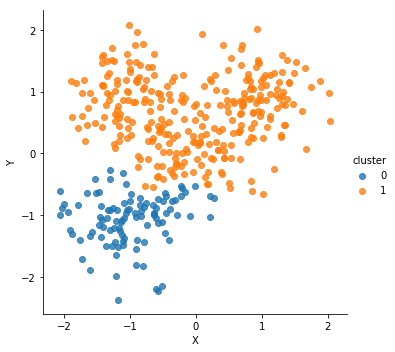

In [90]:
show_clusters(alglomerative_clustering_results.get(2))

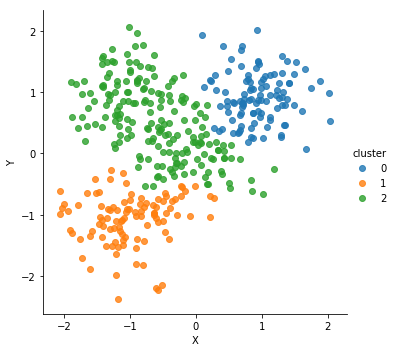

In [91]:
show_clusters(alglomerative_clustering_results.get(3))

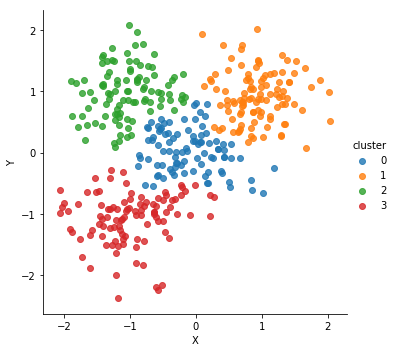

In [92]:
show_clusters(alglomerative_clustering_results.get(4))

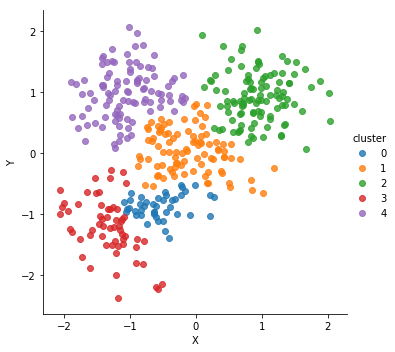

In [163]:
show_clusters(alglomerative_clustering_results.get(5))

**Split the dataset into training and validation datasets (80%/20%). Print out the proportions of classes in all datasets.**

In [164]:
import numpy as np
def split_dataset(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    validate = df[~msk]
    return train, validate

In [165]:
cancer_train, cancer_validate = split_dataset(cancer)

In [166]:
def propotion(df, first_label, second_label, column):
    grouped = df.groupby('label').count()
    return grouped[column][first_label] / (grouped[column][first_label] + grouped[column][second_label] )

In [167]:
propotion(cancer_train, 'B', 'M', '1')

0.621505376344086

In [168]:
propotion(cancer_validate, 'B', 'M', '1')

0.6538461538461539

In [169]:
spam_train, spam_validate = split_dataset(spam)

In [170]:
propotion(spam_train, 0, 1, 'word_freq_make')

0.6031267142073505

In [171]:
propotion(spam_validate, 0, 1, 'word_freq_make')

0.6167539267015707